Figure out how to serialize the compute so it can run with client

In [9]:
import xarray as xr
import numpy as np
import dask as da
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.distributed import Client,progress
from dask.diagnostics import ProgressBar
import time


In [8]:
from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

In [9]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 63.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58006,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 63.25 GiB
Comm: tcp://127.0.0.1:58035,Total threads: 4
Dashboard: http://127.0.0.1:58040/status,Memory: 10.54 GiB
Nanny: tcp://127.0.0.1:58009,


In [2]:

reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={"time": 48},
    storage_options=dict(token='anon'),
)

c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [7]:
#client = Client()
#client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 63.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57602,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 63.25 GiB
Comm: tcp://127.0.0.1:57629,Total threads: 4
Dashboard: http://127.0.0.1:57634/status,Memory: 10.54 GiB
Nanny: tcp://127.0.0.1:57605,


In [3]:
def roll_longitude(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

In [4]:
dx = reanalysis.sel(time=slice('2020-01-01','2020-01-05'))
dx  = roll_longitude(dx)
dx = dx.sel(latitude = slice(90,20),longitude=slice(-150,-40))

In [5]:
dx_array = dx['2m_temperature']


In [6]:
data = dx_array#.mean(dim="time")

In [8]:
data

<xarray.DataArray '2m_temperature' (time: 120, latitude: 281, longitude: 441)>
dask.array<getitem, shape=(120, 281, 441), dtype=float32, chunksize=(48, 281, 441), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float32 -150.0 -149.8 -149.5 ... -40.5 -40.25 -40.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-01-05T23:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

In [7]:
%%time
with ProgressBar():
    teste = data.persist()

[########################################] | 100% Completed | 3.27 ss
CPU times: total: 1.44 s
Wall time: 3.29 s


In [11]:
#!Dont run

teste.to_netcdf('ERA5/arco-era5/data/temp.nc')

In [ ]:
#!Dont run
teste2 = data.mean(dim="time")
%%time
with ProgressBar():
    teste = teste2.compute()

#compute: https://distributed.dask.org/en/stable/manage-computation.html#:~:text=You%20can%20turn%20any%20dask%20collection%20into%20a,collection%20to%20a%20concrete%20value%20in%20local%20memory.
#diagnostic https://dask.pydata.org/en/latest/diagnostics-distributed.html
#scheduler: https://docs.dask.org/en/stable/scheduler-overview.html?highlight=scheduler#configuring-schedulers
#Dask delayed: https://examples.dask.org/applications/embarrassingly-parallel.html

In [10]:
from dask.distributed import performance_report,get_task_stream
teste2 = data.mean(dim="time")



In [14]:
from distributed.protocol import serialize

In [15]:
serialize(teste2)

({'serializer': 'pickle', 'writeable': (True, True, True, True, True, True)},
 [b'\x80\x05\x95\x0f\x00\x01\x00\x00\x00\x00\x00\x8c\x15xarray.core.dataarray\x94\x8c\tDataArray\x94\x93\x94)\x81\x94N}\x94(\x8c\x07_coords\x94}\x94(\x8c\x08latitude\x94\x8c\x14xarray.core.variable\x94\x8c\rIndexVariable\x94\x93\x94)\x81\x94N}\x94(\x8c\x05_dims\x94h\x07\x85\x94\x8c\x05_data\x94\x8c\x14xarray.core.indexing\x94\x8c\x15PandasIndexingAdapter\x94\x93\x94)\x81\x94N}\x94(\x8c\x05array\x94\x8c\x18pandas.core.indexes.base\x94\x8c\n_new_Index\x94\x93\x94h\x16\x8c\x05Index\x94\x93\x94}\x94(\x8c\x04data\x94\x8c\x12numpy.core.numeric\x94\x8c\x0b_frombuffer\x94\x93\x94(\x97\x8c\x05numpy\x94\x8c\x05dtype\x94\x93\x94\x8c\x02f4\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94bM\x19\x01\x85\x94\x8c\x01C\x94t\x94R\x94\x8c\x04name\x94h\x07u\x86\x94R\x94\x8c\x06_dtype\x94h%u\x86\x94b\x8c\x06_attrs\x94}\x94(\x8c\tlong_name\x94\x8c\x08latitude\x94\x8c\x05units\x94\x8c\rdegr

In [16]:
import threading

In [21]:
serialize(data.mean(dim='time'))

({'serializer': 'pickle', 'writeable': (True, True, True, True, True, True)},
 [b'\x80\x05\x95\x0f\x00\x01\x00\x00\x00\x00\x00\x8c\x15xarray.core.dataarray\x94\x8c\tDataArray\x94\x93\x94)\x81\x94N}\x94(\x8c\x07_coords\x94}\x94(\x8c\x08latitude\x94\x8c\x14xarray.core.variable\x94\x8c\rIndexVariable\x94\x93\x94)\x81\x94N}\x94(\x8c\x05_dims\x94h\x07\x85\x94\x8c\x05_data\x94\x8c\x14xarray.core.indexing\x94\x8c\x15PandasIndexingAdapter\x94\x93\x94)\x81\x94N}\x94(\x8c\x05array\x94\x8c\x18pandas.core.indexes.base\x94\x8c\n_new_Index\x94\x93\x94h\x16\x8c\x05Index\x94\x93\x94}\x94(\x8c\x04data\x94\x8c\x12numpy.core.numeric\x94\x8c\x0b_frombuffer\x94\x93\x94(\x97\x8c\x05numpy\x94\x8c\x05dtype\x94\x93\x94\x8c\x02f4\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94bM\x19\x01\x85\x94\x8c\x01C\x94t\x94R\x94\x8c\x04name\x94h\x07u\x86\x94R\x94\x8c\x06_dtype\x94h%u\x86\x94b\x8c\x06_attrs\x94}\x94(\x8c\tlong_name\x94\x8c\x08latitude\x94\x8c\x05units\x94\x8c\rdegr

In [20]:
with get_task_stream(plot='save', filename="task-stream.html") as ts:
    data.mean(dim='time').compute()


2024-09-26 21:34:08,033 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\distributed\protocol\core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\fallback.py", line 885, in pack
    self._pack(obj)
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\fallback.py", line 861, in _pack
    self._pack(obj[i], nest_limit - 1)
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\fallback.py", line 864, in _pack
    return self._pack_map_pairs(
           ^^^^^

FutureCancelledError: ('mean_agg-aggregate-ffcc2eb18a1c7268fb81098a4f1446af', 0, 0) cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

In [13]:
with performance_report(filename="temp/dask-report.html"):
    teste = teste2.compute()

2024-09-26 21:29:14,377 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\distributed\protocol\core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\fallback.py", line 885, in pack
    self._pack(obj)
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\fallback.py", line 861, in _pack
    self._pack(obj[i], nest_limit - 1)
  File "c:\Users\ls2236\AppData\Local\anaconda3\Lib\site-packages\msgpack\fallback.py", line 864, in _pack
    return self._pack_map_pairs(
           ^^^^^

FutureCancelledError: ('mean_agg-aggregate-ffcc2eb18a1c7268fb81098a4f1446af', 0, 0) cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

In [10]:
#check file
file_name = "ERA5/arco-era5/data/2m_temperature_19980101_19990101.nc"
ds =  xr.open_mfdataset(file_name, chunks={'time': 48})

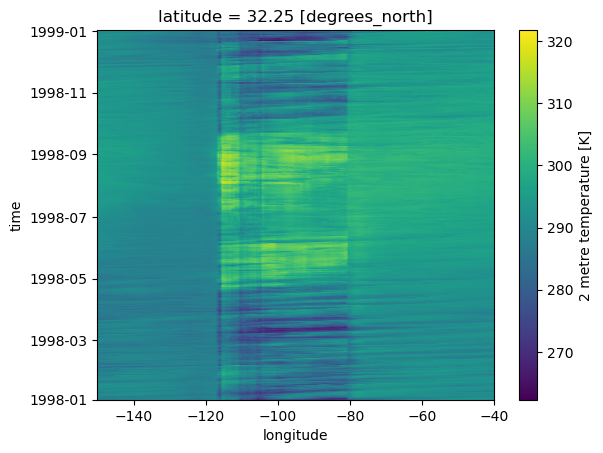

In [17]:
ds.isel(latitude=-50)["2m_temperature"].plot()